## Partial Least Squares Regression (PLS)



### Import Data <a name="import_data"></a>

Import the training and test split datasets generated from "preprocessing.ipynb".

In [3]:
import pandas as pd

data_file_path = '../../data'

train_df = pd.read_csv(f'{data_file_path}/train_data.csv', index_col=0)
test_df = pd.read_csv(f'{data_file_path}/test_data.csv', index_col=0)

# drop 's' column

train_df = train_df.copy().drop(columns='s')
test_df = test_df.copy().drop(columns='s')

### Grid Search <a name="grid_search"></a>

In [16]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, r2_score
import pandas as pd

# Suppose you already have train_df and test_df
# with 'y' as your target column

X_train = train_df.drop(columns='y')
y_train = train_df['y']

# Define PLS model (no n_components specified yet)
pls = PLSRegression(scale=True, copy=True)

# Define the parameter grid for n_components
param_grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_iter': [500, 1000, 5000, 10000],
    'tol': [1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
}

# Define a cross-validation strategy
cv = KFold(n_splits=10, shuffle=True)

# Optionally define a scoring metric (or just pass a string to 'scoring')
# scoring = make_scorer(r2_score)

grid_search = GridSearchCV(
    estimator=pls,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # 'r2'
    cv=cv,
    n_jobs=1,
    verbose=1
)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=PLSRegression(), n_jobs=1,
             param_grid={'max_iter': [500, 1000, 5000, 10000],
                         'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12],
                         'tol': [1e-09, 1e-10, 1e-11, 1e-12, 1e-13]},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
# Get the cross-validation results as a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Sort rows by n_components (sometimes helpful for clean plotting)
results = results.sort_values(by='param_n_components')

# Extract the parameter values, mean test score, and std test score
n_comps = results['param_n_components']
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

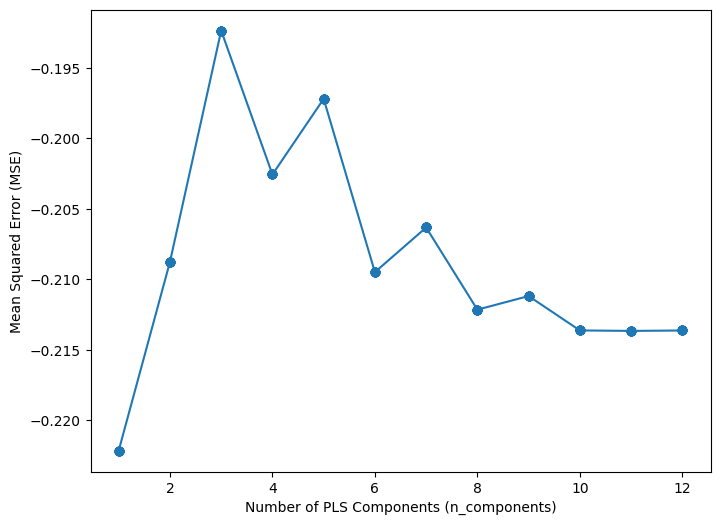

In [39]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 6))

# 1) Left axis: Mean CV R^2 with error bars
color_left = 'tab:blue'
ax1.errorbar(
    n_comps,
    mean_scores,
    fmt='-o',
    capsize=5,
    color=color_left,
    label='Mean CV Score ± 1 Std. Dev.'
)
ax1.set_xlabel('Number of PLS Components (n_components)')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.tick_params(axis='y')

plt.show()


#### Base Model Training <a name="base_model_training"></a>


In [17]:
print(grid_search.best_params_)

{'max_iter': 500, 'n_components': 3, 'tol': 1e-09}


In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [('pls', PLSRegression(n_components=grid_search.best_params_['n_components'],
                    scale=True,
                    max_iter=grid_search.best_params_['max_iter'],
                    tol=grid_search.best_params_['tol'],
                    copy=True))]

base_model = StackingClassifier(estimators=estimators,
                                final_estimator=LogisticRegression(penalty='l2'))

base_model.fit(X=train_df.copy().drop(columns='y'), y=train_df['y'])

StackingClassifier(estimators=[('pls',
                                PLSRegression(n_components=3, tol=1e-09))],
                   final_estimator=LogisticRegression())

In [28]:
base_model.estimators[0][1]

PLSRegression(n_components=3, tol=1e-09)

#### Cross Validation

In [19]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(base_model,
                         X=train_df.copy().drop(columns='y'),
                         y=train_df['y'], cv=5, scoring='accuracy')
scores

array([0.77777778, 0.77777778, 0.53846154, 0.69230769, 0.80769231])

### Variable Importance in Projection (VIP) Feature Selection

In [21]:
import numpy as np

def compute_vip(pls, X):
    """
    Compute the Variable Importance in Projection (VIP) scores for each predictor (wavenumber).

    Parameters
    ----------
    pls : trained PLSRegression object
        A fitted scikit-learn PLSRegression model.
    X : ndarray or pandas dataframe, shape (n_samples, n_features)
        Training data on which the model was fit (or at least the same shape/features).

    Returns
    -------
    vip_scores : ndarray of shape (n_features,)
        VIP score for each feature (wavenumber).
    """
    # Extract the necessary parameters from the PLS model
    T = pls.x_scores_           # (n_samples, n_components)
    W = pls.x_weights_          # (n_features, n_components)
    Q = pls.y_loadings_.ravel() # (n_components,)

    # Number of features and components
    p, A = W.shape

    # Sum of squares explained by each component for Y
    # SS(t_h * q_h) ~ sum over all samples of (t_h * q_h)^2
    # We can do that by (T[:,h] * Q[h])^2 and summing
    SS = np.sum((T * Q)**2, axis=0)  # shape (n_components,)
    total_SS = np.sum(SS)           # total sum of squares

    # Initialize VIP array
    vip_scores = np.zeros(p)

    # For each component h
    for h in range(A):
        # Weight for feature j on component h = W[j,h]
        # Contribution factor = (T[:,h] * Q[h])^2
        # So we add the share of the SS explained by component h, scaled by W[j,h]^2
        vip_scores += (SS[h] * (W[:, h]**2)) / total_SS

    # Multiply by p and take the square root
    vip_scores = np.sqrt(p * vip_scores)
    return vip_scores

def sliding_window_smooth(values, window_size=20):
    """
    Smooth values with a simple moving average over `window_size`.
    """
    kernel = np.ones(window_size) / window_size
    return np.convolve(values, kernel, mode='same')

#### VIP Model Training

In [30]:
# pls fit
pls = PLSRegression(n_components=grid_search.best_params_['n_components'],
                    scale=True,
                    max_iter=grid_search.best_params_['max_iter'],
                    tol=grid_search.best_params_['tol'],
                    copy=True)


pls.fit(X=train_df.copy().drop(columns='y'), y=train_df['y'])

PLSRegression(n_components=3, tol=1e-09)

In [31]:
vip = compute_vip(pls, train_df.copy().drop(columns='y'))

window_size = 11

vip_smoothed = sliding_window_smooth(vip, window_size=window_size)

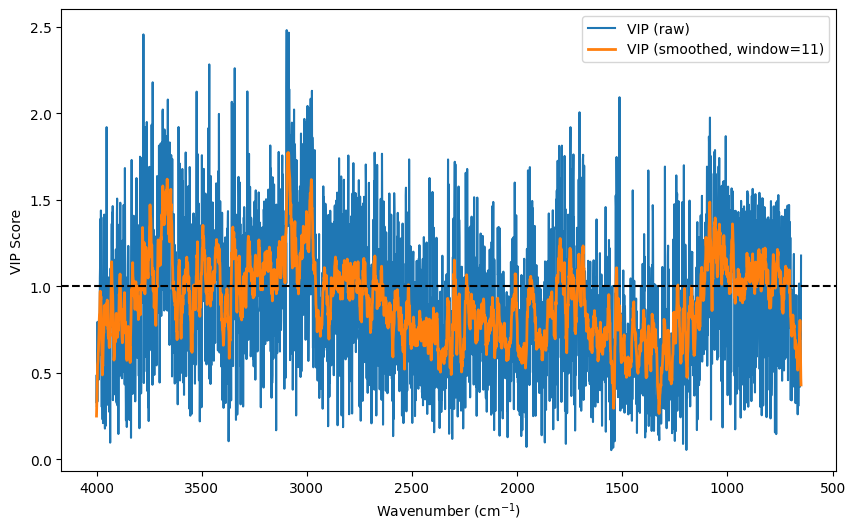

In [58]:
wavenumbers = np.linspace(4000, 650, num=train_df.shape[1]-1)

plt.figure(figsize=(10, 6))

plt.plot(wavenumbers, vip, label='VIP (raw)')
plt.plot(wavenumbers, vip_smoothed, label=f'VIP (smoothed, window={window_size})', linewidth=2)
plt.axhline(y=1.0, linestyle='dashed', color='black')

plt.gca().invert_xaxis()  # Often MIR spectra are plotted from high to low wavenumber
plt.xlabel("Wavenumber (cm$^{-1}$)")
plt.ylabel("VIP Score")
#plt.title("Variable Importance in Projection (VIP) Across Wavenumbers")
plt.legend()
plt.savefig('../../figures/vip_scores.png', dpi=600)

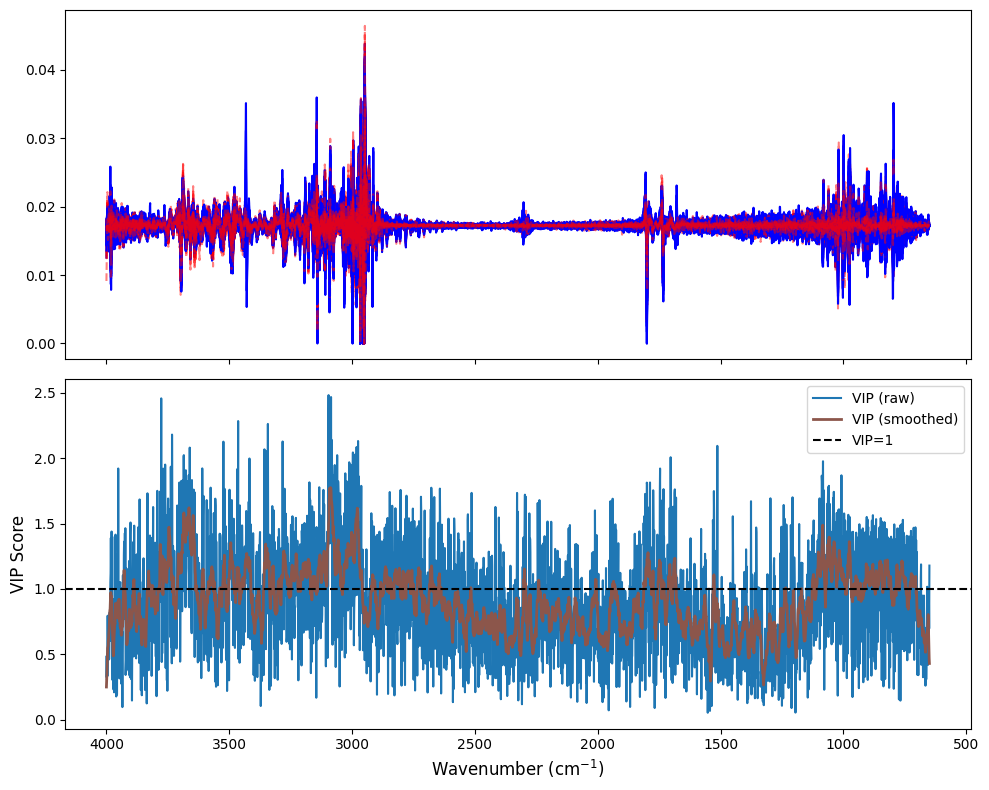

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Example: wavenumbers goes from 4000 to 650
wavenumbers = np.linspace(4000, 650, num=train_df.shape[1] - 1)

# Example data from train_df
# (You might plot the mean or a specific row/column—make sure it matches `wavenumbers` in length)
train_mean = train_df.copy().drop(columns='y').mean(axis=0)  # just as an example

# Set up a figure with 2 subplots (stacked vertically), sharing the same x-axis
fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

# 1) TOP SUBPLOT: train_df data
#ax_top.plot(wavenumbers, train_mean, label='Train DF (mean)', color='tab:blue')
#ax_top.set_ylabel("Absorbance", fontsize=12)
#ax_top.legend(loc='upper right')

x = np.arange(4000, 650, -1)  # last argument is exclusive, so 649 means it stops at 650

# Iterate over each row (spectrum) in your filtered DataFrame
for index, row in train_df.copy().drop(columns='y').iterrows():
    # Use 'x' for the x-axis and the row values for the y-axis
    if train_df.loc[index, 'y'] == 1:
        ax_top.plot(x, row.values, color='red', linestyle='--', alpha=0.5)
    else:
        ax_top.plot(x, row.values, color='blue')

# Because we used `sharex=True`, inverting the top x-axis will also invert the bottom’s x-axis
ax_top.invert_xaxis()  # so wavenumbers go high -> low

# 2) BOTTOM SUBPLOT: VIP curves
ax_bottom.plot(wavenumbers, vip, label='VIP (raw)', color='tab:blue')
ax_bottom.plot(wavenumbers, vip_smoothed, label='VIP (smoothed)', linewidth=2, color='tab:brown')
ax_bottom.axhline(y=1.0, linestyle='dashed', color='black', label='VIP=1')

ax_bottom.set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=12)
ax_bottom.set_ylabel("VIP Score", fontsize=12)
ax_bottom.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../../figures/vip_scores.png', dpi=600)
plt.show()


In [46]:
def subset_dataframe_by_vip(df, feature_cols, vip_scores, threshold=1.0):
    """
    Subset a DataFrame (which may contain extra, non-spectral columns)
    by keeping only those spectral columns whose VIP score is >= threshold,
    while retaining any non-spectral columns.

    Parameters
    ----------
    df : pd.DataFrame
        The entire DataFrame containing both spectral and non-spectral columns.
    feature_cols : list of str
        The column names in df that correspond exactly (and in the same order)
        to the VIP scores.
    vip_scores : array-like of shape (len(feature_cols),)
        The VIP scores for each spectral column in feature_cols.
    threshold : float, optional (default=1.0)
        The VIP threshold. Only spectral columns with VIP >= threshold are kept.

    Returns
    -------
    df_subset : pd.DataFrame
        A DataFrame that:
          - Retains all non-spectral columns from df
          - Keeps only the spectral columns whose VIP >= threshold
    """
    # Convert vip_scores to a NumPy array for easier masking
    vip_scores = np.asarray(vip_scores)

    # Check that feature_cols and vip_scores align in length
    if len(feature_cols) != len(vip_scores):
        raise ValueError(
            f"Number of feature_cols ({len(feature_cols)}) must match "
            f"length of vip_scores ({len(vip_scores)})."
        )

    # Determine which spectral columns pass the VIP threshold
    keep_mask = (vip_scores >= threshold)
    kept_spectral_cols = [col for col, keep in zip(feature_cols, keep_mask) if keep]

    # Collect any columns in df that are NOT in feature_cols (e.g., 'y', IDs, etc.)
    non_spectral_cols = [col for col in df.columns if col not in feature_cols]

    # Final columns to keep = all non-spectral columns + the kept spectral columns
    cols_to_keep = non_spectral_cols + kept_spectral_cols

    # Subset the original df
    df_subset = df[cols_to_keep]

    return df_subset

In [47]:
feature_cols = [c for c in train_df.columns if c not in ['y']]

# 'vip' is the array of VIP scores computed in exactly that order
# e.g. vip[i] corresponds to feature_cols[i].

df_train_subset = subset_dataframe_by_vip(
    df=train_df,
    feature_cols=feature_cols,
    vip_scores=vip_smoothed,
    threshold=1
)

df_test_subset = subset_dataframe_by_vip(
    df=test_df,
    feature_cols=feature_cols,
    vip_scores=vip_smoothed,
    threshold=1
)

In [50]:
# Suppose you already have train_df and test_df
# with 'y' as your target column

X_train = df_train_subset.drop(columns='y')
y_train = df_train_subset['y']

# Define PLS model (no n_components specified yet)
pls = PLSRegression(scale=True, copy=True)

# Define the parameter grid for n_components
param_grid = {
    'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'max_iter': [500, 1000, 5000, 10000],
    'tol': [1e-9, 1e-10, 1e-11, 1e-12, 1e-13]
}

# Define a cross-validation strategy
cv = KFold(n_splits=10, shuffle=True)

# Optionally define a scoring metric (or just pass a string to 'scoring')
# scoring = make_scorer(r2_score)

grid_search_vip = GridSearchCV(
    estimator=pls,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', # 'r2'
    cv=cv,
    n_jobs=1,
    verbose=1
)

# Fit the grid search on training data
grid_search_vip.fit(X_train, y_train)

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=PLSRegression(), n_jobs=1,
             param_grid={'max_iter': [500, 1000, 5000, 10000],
                         'n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12],
                         'tol': [1e-09, 1e-10, 1e-11, 1e-12, 1e-13]},
             scoring='neg_mean_squared_error', verbose=1)

In [52]:
print(grid_search_vip.best_params_)

{'max_iter': 500, 'n_components': 8, 'tol': 1e-09}


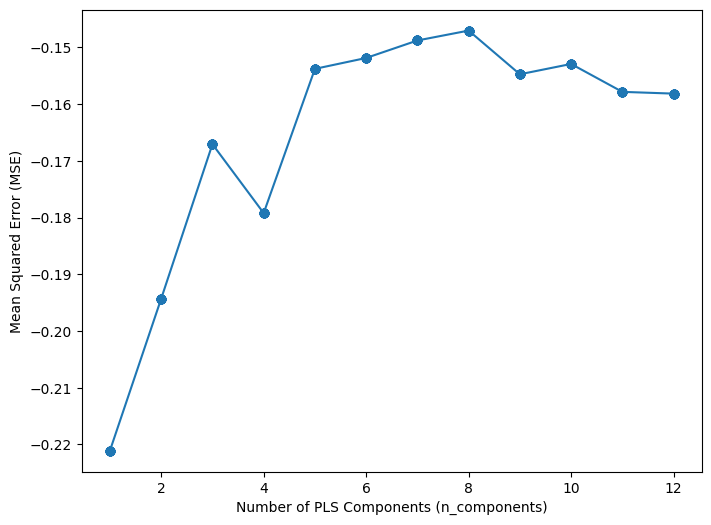

In [53]:
# Get the cross-validation results as a DataFrame
results = pd.DataFrame(grid_search_vip.cv_results_)

# Sort rows by n_components (sometimes helpful for clean plotting)
results = results.sort_values(by='param_n_components')

# Extract the parameter values, mean test score, and std test score
n_comps = results['param_n_components']
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

fig, ax1 = plt.subplots(figsize=(8, 6))

# 1) Left axis: Mean CV R^2 with error bars
color_left = 'tab:blue'
ax1.errorbar(
    n_comps,
    mean_scores,
    fmt='-o',
    capsize=5,
    color=color_left,
    label='Mean CV Score ± 1 Std. Dev.'
)
ax1.set_xlabel('Number of PLS Components (n_components)')
ax1.set_ylabel('Mean Squared Error (MSE)')
ax1.tick_params(axis='y')

plt.show()

In [54]:
estimators = [('pls', PLSRegression(n_components=grid_search_vip.best_params_['n_components'],
                    scale=True,
                    max_iter=grid_search_vip.best_params_['max_iter'],
                    tol=grid_search_vip.best_params_['tol'],
                    copy=True))]

vip_model = StackingClassifier(estimators=estimators,
                                final_estimator=LogisticRegression(penalty='l2'))

vip_model.fit(X=df_train_subset.copy().drop(columns='y'), y=df_train_subset['y'])

StackingClassifier(estimators=[('pls',
                                PLSRegression(n_components=8, tol=1e-09))],
                   final_estimator=LogisticRegression())

### Base and VIP Model Evaluation

In [44]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.utils import resample

# base model
y_pred_base = base_model.predict(test_df.copy().drop(columns='y'))

# Calculate metrics
cm = confusion_matrix(test_df['y'], y_pred_base)
recall = recall_score(test_df['y'], y_pred_base)
precision = precision_score(test_df['y'], y_pred_base)
accuracy = accuracy_score(test_df['y'], y_pred_base)
f1 = f1_score(test_df['y'], y_pred_base)

# Number of bootstrap samples
n_bootstraps = 1000

# Create arrays to store bootstrap results
recall_scores = []
precision_scores = []
accuracy_scores = []
f1_scores = []

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the data
    indices = resample(range(len(test_df['y'])), replace=True)
    y_true_resampled = test_df['y'].iloc[indices]
    y_pred_resampled = np.array(y_pred_base)[indices]

    # Compute metrics for resampled data
    recall_scores.append(recall_score(y_true_resampled, y_pred_resampled))
    precision_scores.append(precision_score(y_true_resampled, y_pred_resampled))
    accuracy_scores.append(accuracy_score(y_true_resampled, y_pred_resampled))
    f1_scores.append(f1_score(y_true_resampled, y_pred_resampled))

# Calculate confidence intervals (e.g., 95%)
recall_ci = np.percentile(recall_scores, [2.5, 97.5])
precision_ci = np.percentile(precision_scores, [2.5, 97.5])
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

# Print confidence intervals
print(f"Recall CI: {recall_ci}")
print(f"Precision CI: {precision_ci}")
print(f"Accuracy CI: {accuracy_ci}")
print(f"F1 Score CI: {f1_ci}")
# Create a table for metrics
base_model_metrics = pd.DataFrame({
    "Metric": ["Recall/Sensitivity", "Precision/Specificity", "Accuracy", "F1 Score"],
    "Value": [recall, precision, accuracy, f1],
    "CI (2.5%)": [recall_ci[0], precision_ci[0], accuracy_ci[0], f1_ci[0]],
    "CI (97.5%)": [recall_ci[1], precision_ci[1], accuracy_ci[1], f1_ci[1]]
})

Recall CI: [0.76463585 1.        ]
Precision CI: [0.7 1. ]
Accuracy CI: [0.73529412 0.97058824]
F1 Score CI: [0.76470588 0.97146718]


In [45]:
# Display the table
base_model_metrics.to_csv(f'../../tables/base_model_metrics.csv', index=False)
base_model_metrics

,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.904762,0.764636,1.000000
1,Precision/Specificity,0.863636,0.700000,1.000000
2,Accuracy,0.852941,0.735294,0.970588
3,F1 Score,0.883721,0.764706,0.971467


In [55]:
# base model
y_pred_vip = vip_model.predict(df_test_subset.copy().drop(columns='y'))

# Calculate metrics
cm = confusion_matrix(df_test_subset['y'], y_pred_vip)
recall = recall_score(df_test_subset['y'], y_pred_vip)
precision = precision_score(df_test_subset['y'], y_pred_vip)
accuracy = accuracy_score(df_test_subset['y'], y_pred_vip)
f1 = f1_score(df_test_subset['y'], y_pred_vip)

# Number of bootstrap samples
n_bootstraps = 1000

# Create arrays to store bootstrap results
recall_scores = []
precision_scores = []
accuracy_scores = []
f1_scores = []

# Perform bootstrapping
for _ in range(n_bootstraps):
    # Resample the data
    indices = resample(range(len(df_test_subset['y'])), replace=True)
    y_true_resampled = df_test_subset['y'].iloc[indices]
    y_pred_resampled = np.array(y_pred_vip)[indices]

    # Compute metrics for resampled data
    recall_scores.append(recall_score(y_true_resampled, y_pred_resampled))
    precision_scores.append(precision_score(y_true_resampled, y_pred_resampled))
    accuracy_scores.append(accuracy_score(y_true_resampled, y_pred_resampled))
    f1_scores.append(f1_score(y_true_resampled, y_pred_resampled))

# Calculate confidence intervals (e.g., 95%)
recall_ci = np.percentile(recall_scores, [2.5, 97.5])
precision_ci = np.percentile(precision_scores, [2.5, 97.5])
accuracy_ci = np.percentile(accuracy_scores, [2.5, 97.5])
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

# Print confidence intervals
print(f"Recall CI: {recall_ci}")
print(f"Precision CI: {precision_ci}")
print(f"Accuracy CI: {accuracy_ci}")
print(f"F1 Score CI: {f1_ci}")
# Create a table for metrics
vip_model_metrics = pd.DataFrame({
    "Metric": ["Recall/Sensitivity", "Precision/Specificity", "Accuracy", "F1 Score"],
    "Value": [recall, precision, accuracy, f1],
    "CI (2.5%)": [recall_ci[0], precision_ci[0], accuracy_ci[0], f1_ci[0]],
    "CI (97.5%)": [recall_ci[1], precision_ci[1], accuracy_ci[1], f1_ci[1]]
})

Recall CI: [0.76458824 1.        ]
Precision CI: [0.76190476 1.        ]
Accuracy CI: [0.76470588 0.97058824]
F1 Score CI: [0.79069767 0.97959184]


In [56]:
# Display the table
vip_model_metrics.to_csv(f'../../tables/vip_model_metrics.csv', index=False)
vip_model_metrics


,Metric,Value,CI (2.5%),CI (97.5%)
0,Recall/Sensitivity,0.904762,0.764588,1.000000
1,Precision/Specificity,0.904762,0.761905,1.000000
2,Accuracy,0.882353,0.764706,0.970588
3,F1 Score,0.904762,0.790698,0.979592
